In [1]:
import sys
sys.path.append('../')
from bayes_opt import DiscreteBayesianOptimization, UtilityFunction
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# Target Function

Lets create a target 1-D function with multiple local maxima to test and visualize how the optimization works. The target function we will try to maximize is the following:

$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}, $$ its maximum is at $x = 2$ and we will restrict the interval of interest to $x \in (-2, 10)$. With a precision available $0.001$. 

Notice that, in practice, this function is unknown, the only information we have is obtained by sequentialy probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.


In [2]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

In [3]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1) + 2*np.exp(-(x - 5)**2) + np.exp(-(x - 8)**2/10) +np.exp(-(x - 10)**2)

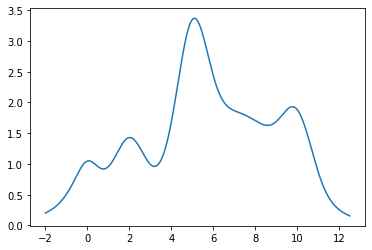

In [4]:
x = np.linspace(-2, 12.5, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y);

# Create a DiscreteBayesianOptimization object

In [5]:
# PARAMETERS
prange = {'x':(-2,12.5,0.1)}
random_state = 1234
sampler = 'KMBBO'
kwargs = {'multiprocessing':1,
         'n_warmup':5}
batch_size = 3

KMBBO_steps=4
greedy_steps=2
# Initialize optimizer and utility function 
dbo = DiscreteBayesianOptimization(f=None,
                                  prange=prange,
                                  random_state=random_state)
utility = UtilityFunction(kind='ucb', kappa=5, xi=0.0)



# Visualization functions 

In [6]:
import matplotlib
matplotlib.matplotlib_fname()
matplotlib.font_manager._rebuild()


In [7]:
plt.rcParams['font.sans-serif']

['DejaVu Sans',
 'Bitstream Vera Sans',
 'Computer Modern Sans Serif',
 'Lucida Grande',
 'Verdana',
 'Geneva',
 'Lucid',
 'Arial',
 'Helvetica',
 'Avant Garde',
 'sans-serif']

In [8]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
#     fig.suptitle(
#         'Bayesian optimization of a Gaussian process',
#         fontdict={'size':30}
#     )
    plt.rcParams['font.sans-serif'] = "DejaVu Sans"
    plt.rcParams['font.family'] = "sans-serif"
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Activity')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 12.5))
    axis.set_ylim((-0.5, 4.0))
    axis.set_ylabel('Hydrogen generation', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='green')
#     acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
#              label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 12.5))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=1, borderaxespad = 0.5)
    acq.legend(loc=1, borderaxespad =0.5)
    plt.savefig('./'+str(steps)+'.png',dpi=300)
def step(dbo,sampler='KMBBO', **kwargs):
    batch = dbo.suggest(utility, sampler = sampler, n_acqs = batch_size,  fit_gp = True, **kwargs)
    for point in batch:
        dbo.register(params=point,target=target(**point))
    plot_gp(dbo,x,y)

## First points are random, beacuse we have no informaiton:
Lets assume a batch size of 3 tests per. 
Maybe we sample the end members.

We will also try once with the KMBBO sampler and the parallel greedy sampling. 

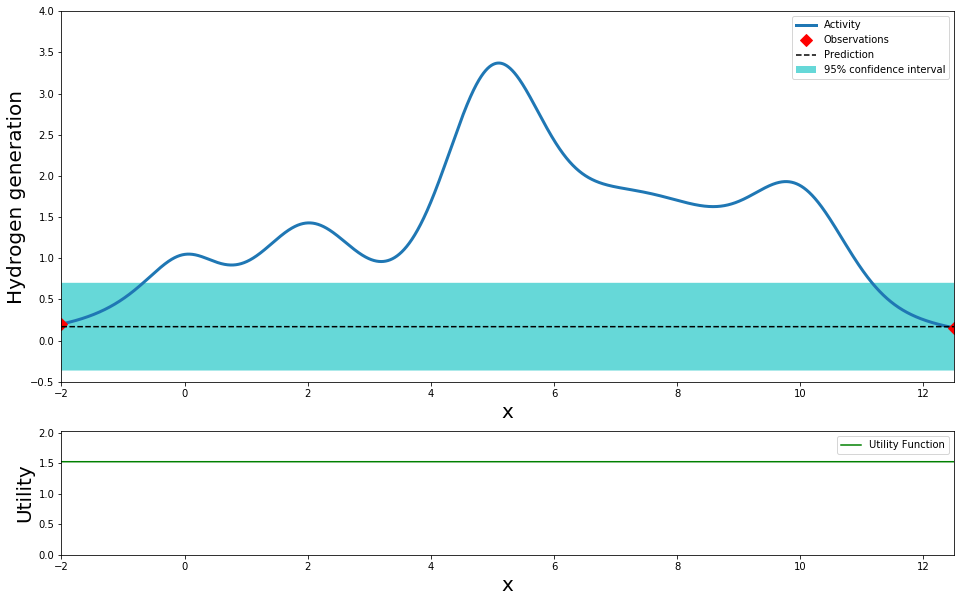

In [9]:
batch = [{'x':-2},{'x':12.5}]
for point in batch:
    dbo.register(params=point,target=target(**point))
plot_gp(dbo,x,y)

## Step 2 

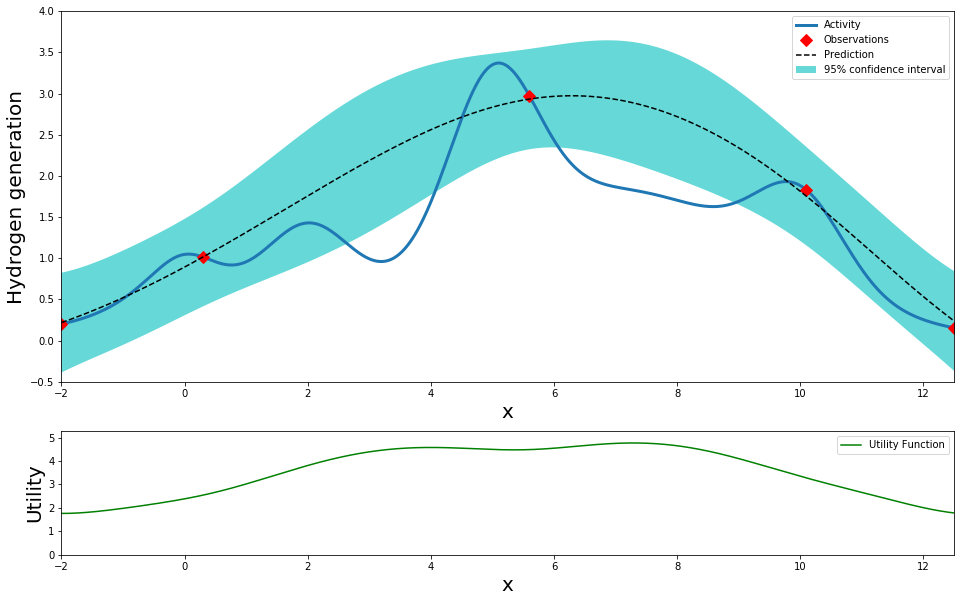

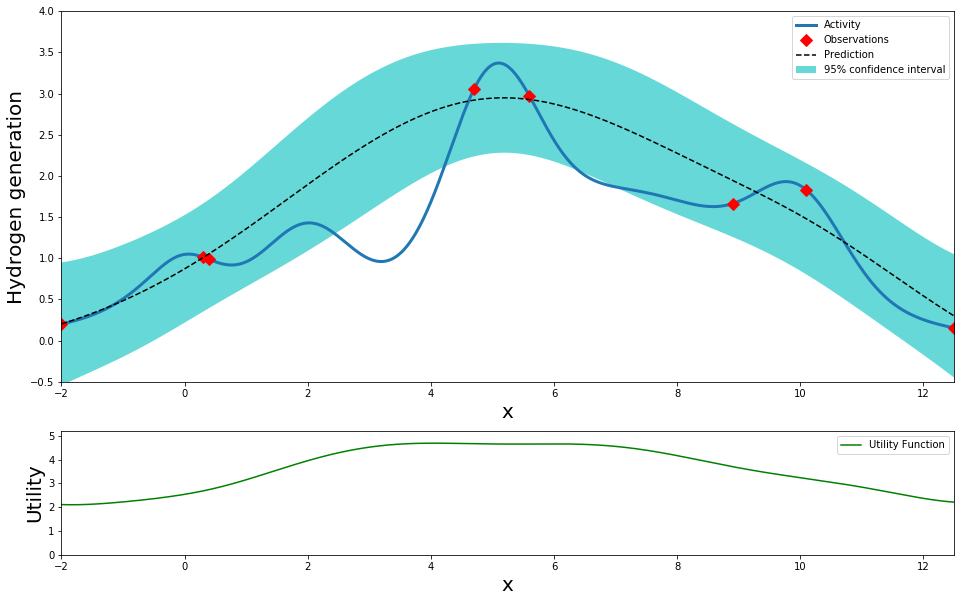

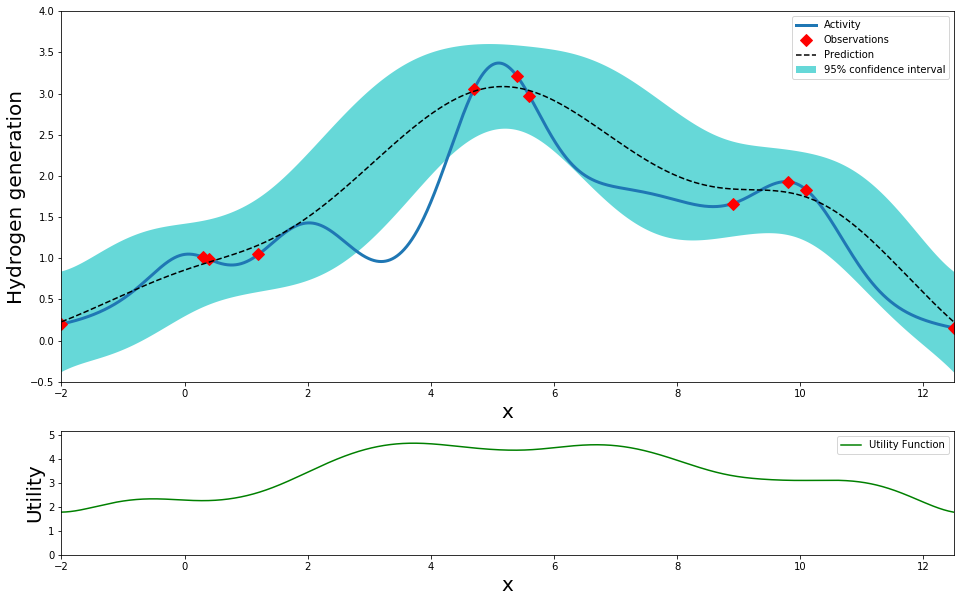

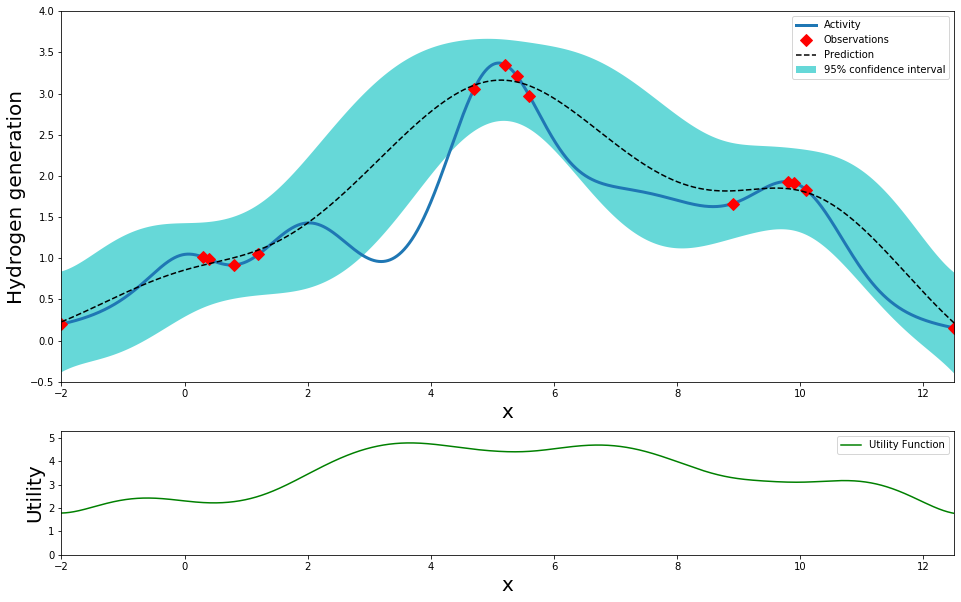

In [10]:
for _ in range(KMBBO_steps):
    step(dbo, **kwargs)

##  Step 3
Greedy finish

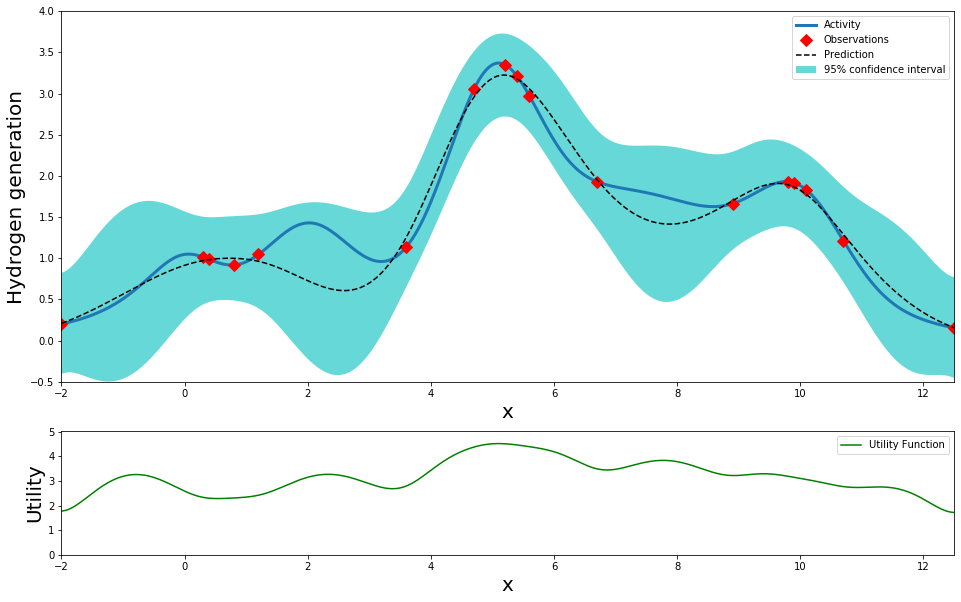

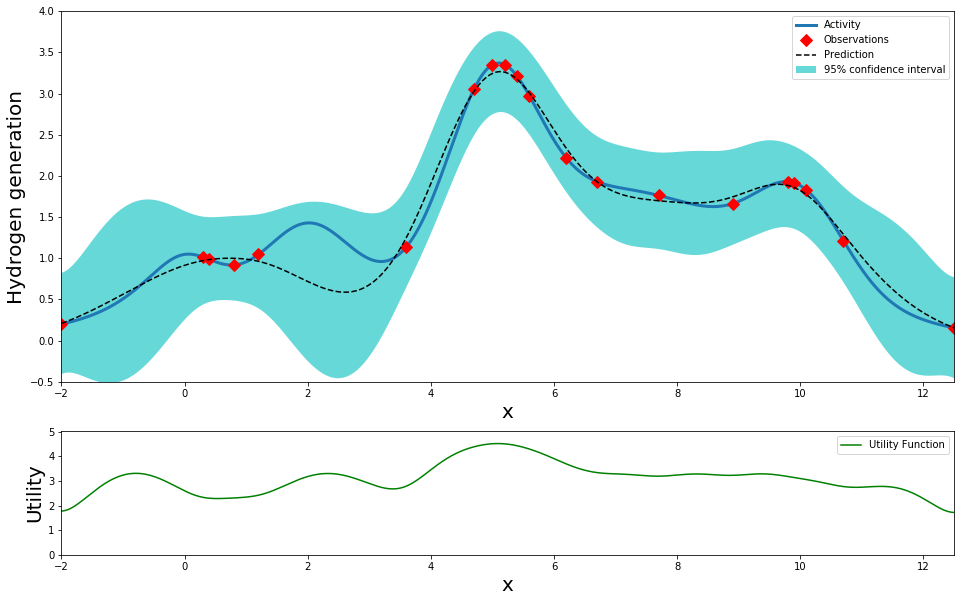

In [11]:
for _ in range(greedy_steps):
    step(dbo,'greedy', **kwargs)

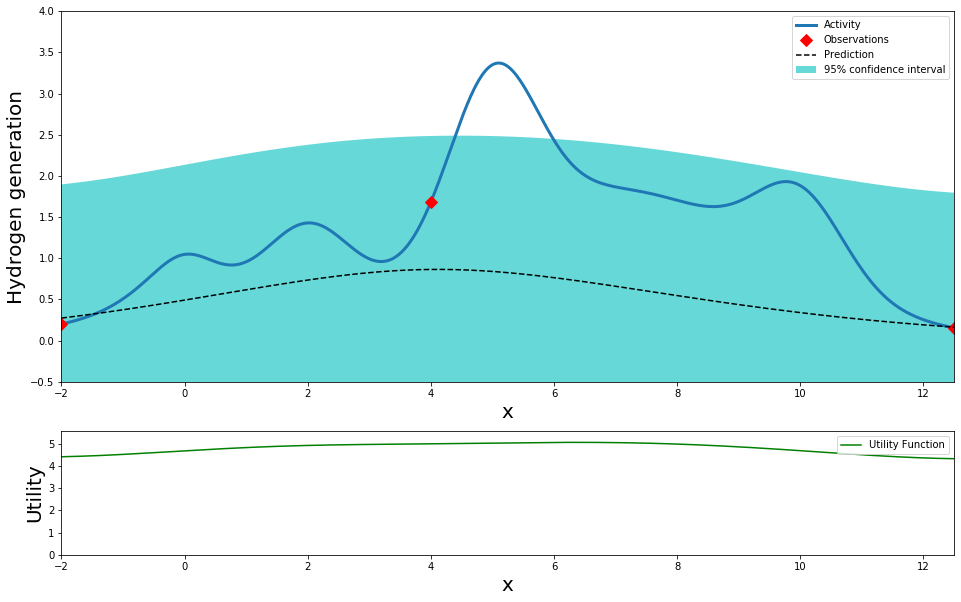

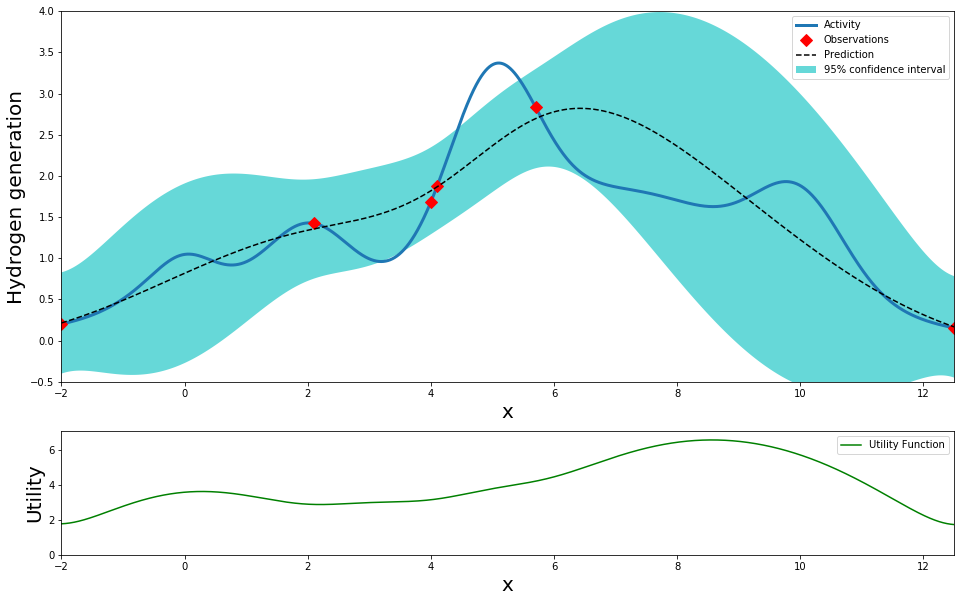

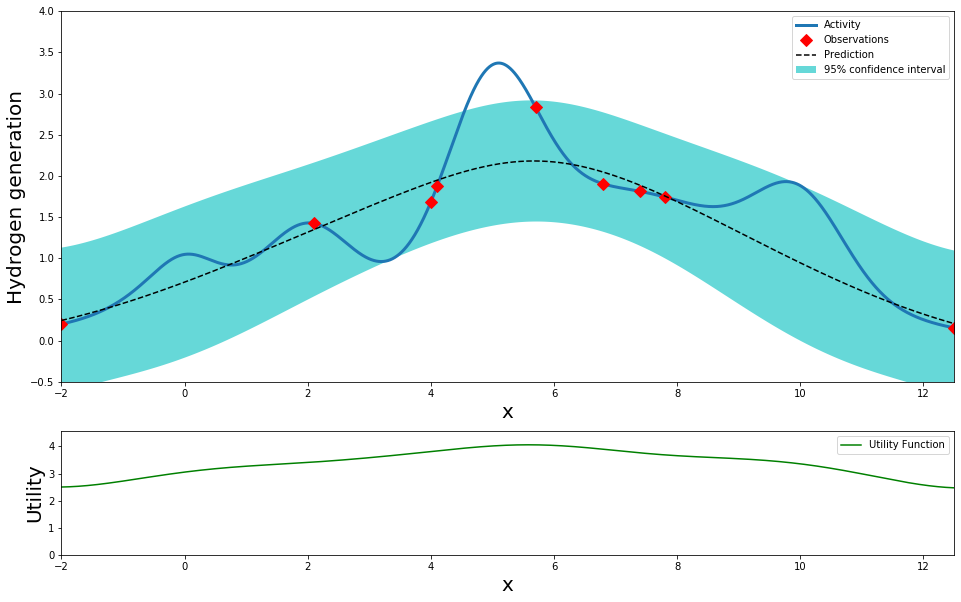

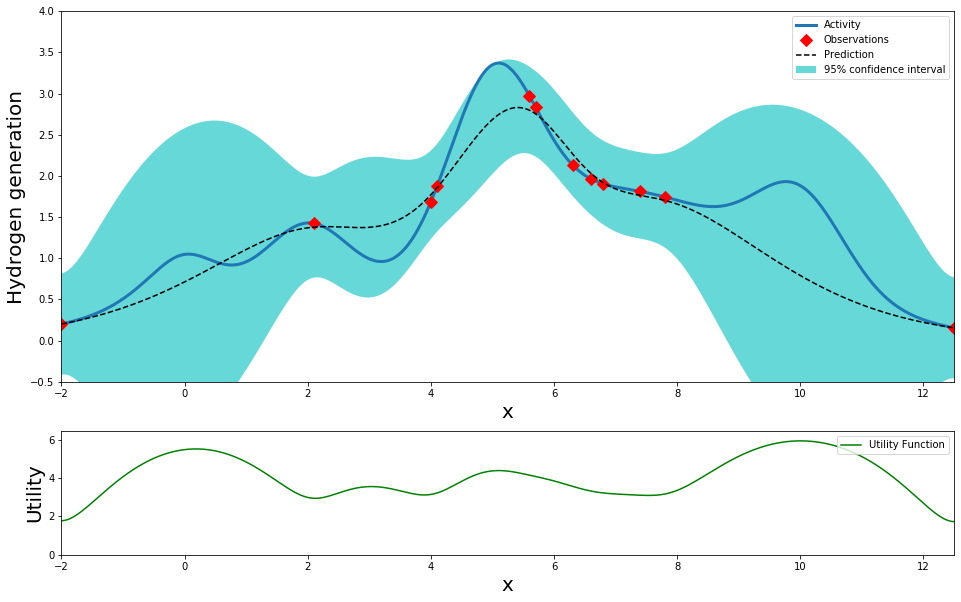

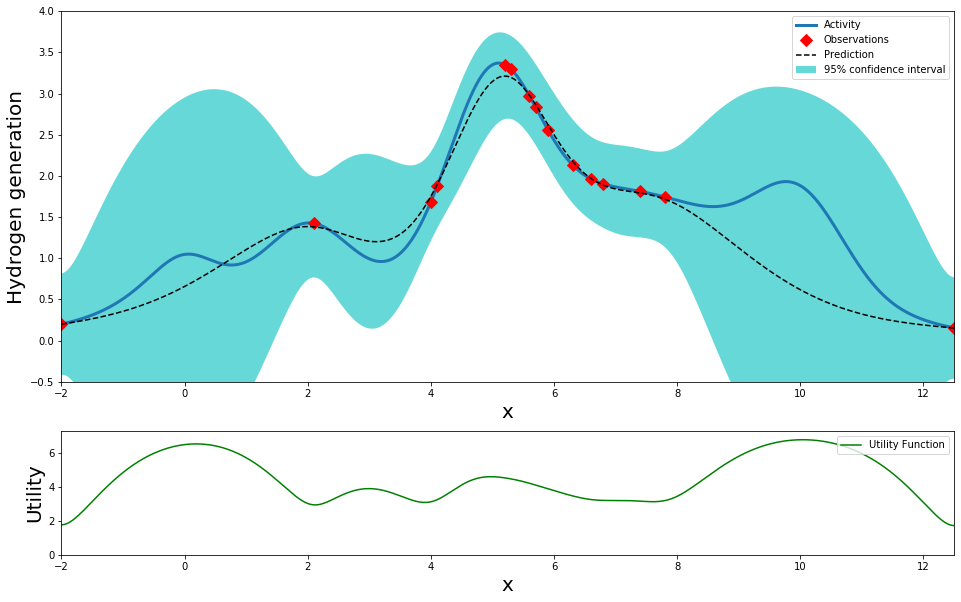

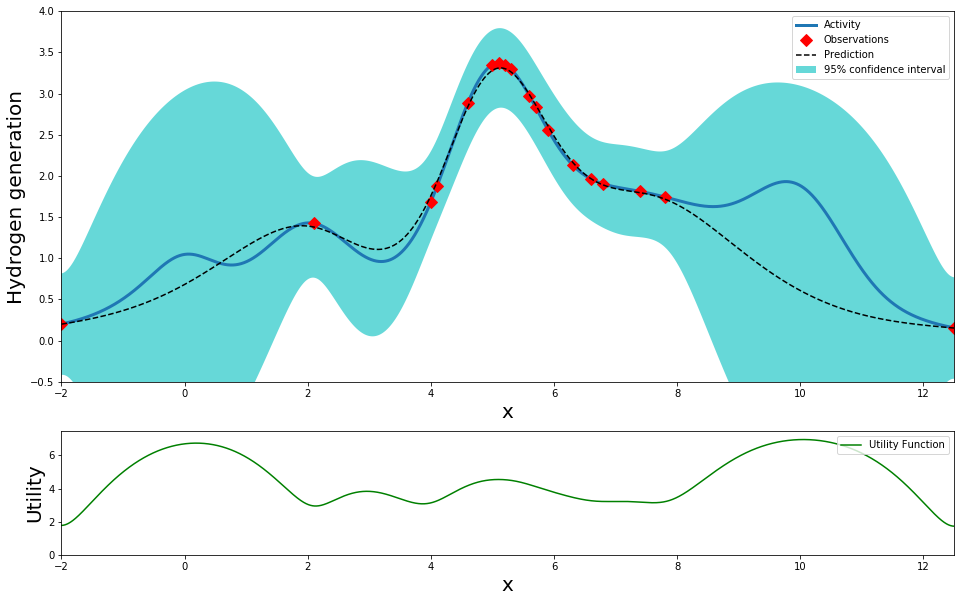

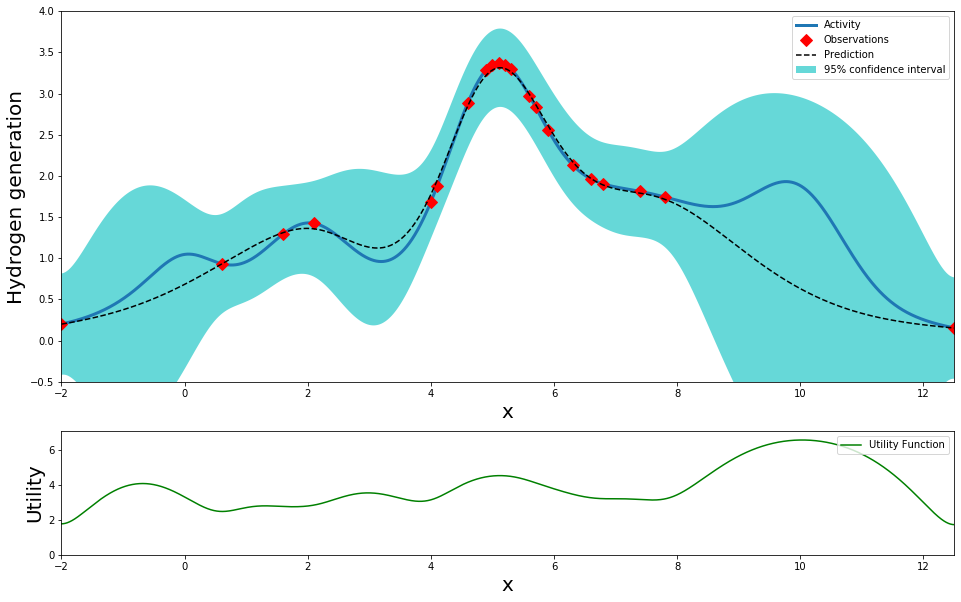

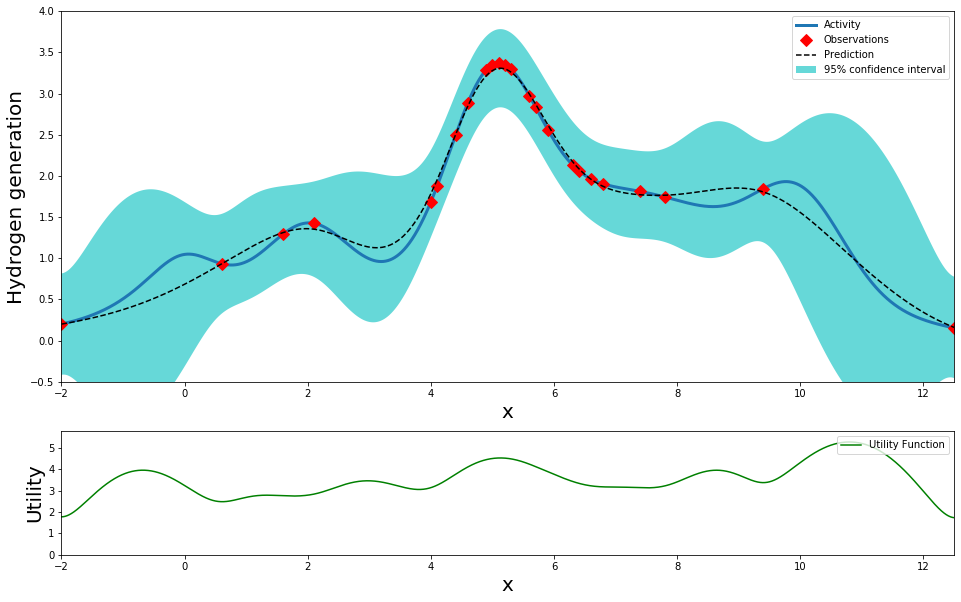

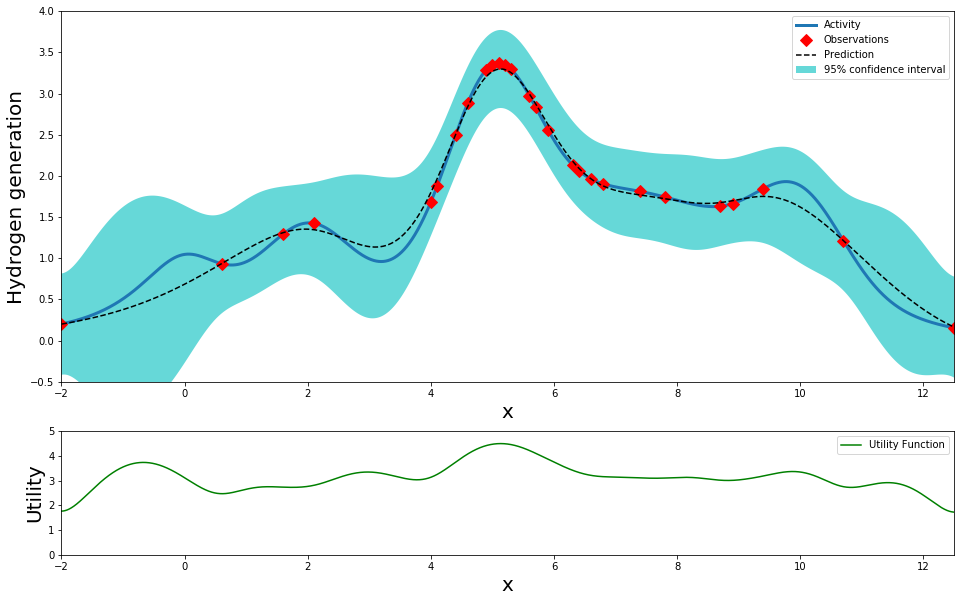

In [12]:
# PARAMETERS
prange = {'x':(-2,12.5,0.1)}
random_state = 1234
kwargs = {'multiprocessing':1,
         'n_warmup':5,
         'n_splits':3}
batch_size = 3

capitalist_steps=8
# Initialize optimizer and utility function 
dbo = DiscreteBayesianOptimization(f=None,
                                  prange=prange,
                                  random_state=random_state)
utility = UtilityFunction(kind='ucb', kappa=5, xi=0.0)
batch = [{'x':-2},{'x':4},{'x':12.5}]
for point in batch:
    dbo.register(params=point,target=target(**point))
plot_gp(dbo,x,y)
for _ in range(capitalist_steps):
    step(dbo,'capitalist',**kwargs)